<a href="https://colab.research.google.com/github/bjoyita/Tutorials_mdxp/blob/main/2pointstats.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
#from skimage import io, color
#from skimage.filters import difference_of_gaussians, window
from scipy.fft import fftn, fftshift
#from skimage.segmentation import clear_border

In [2]:
pip install pymks

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.7/527.7 kB 12.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached jedi-0.19.1-py2.py3-none-any.whl.metadata (22 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 234.7/234.7 kB 11.9 MB/s eta 0:00:00
Using cached jedi-0.19.1-py2.py3-none-any.whl (1.6 MB)
  Created wheel for pymks: filename=pymks-0.4.1-py3-none-any.whl size=551159 sha256=8eed8540e452d2878c4d140ce04538fbab0b443fc203d40c36b502576d4f90dd
  Stored in directory: /root/.cache/pip/wheels/cd/29/6b/7c895f67abfac3c99e0d7b4b8a9ad1fd268fffcfb28c405021
Successfully built pymks


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from PIL import Image
from skimage import io, color
from skimage.color import rgb2gray

from sklearn.pipeline import Pipeline

from pymks import (
    generate_multiphase,
    plot_microstructures,
    PrimitiveTransformer,
    TwoPointCorrelation,
    FlattenTransformer
)

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


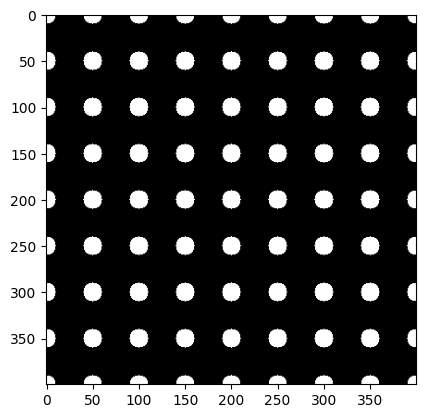

In [4]:
Box = np.zeros((400,400))

# OPEN GRID
x, y = np.ogrid[:400, :400]

for i in range(0,420,50):
    for j in range(0,420,50):
        circles = (x-i)**2 + (y-j)**2 <= 10**2
        Box[circles] = 1.0



plt.imshow(Box, cmap ='gray')



In [5]:
Box_h=np.histogram(Box, bins=100)
Box_h

(array([139712,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,  20288]),
 array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
        0.11, 0.12, 

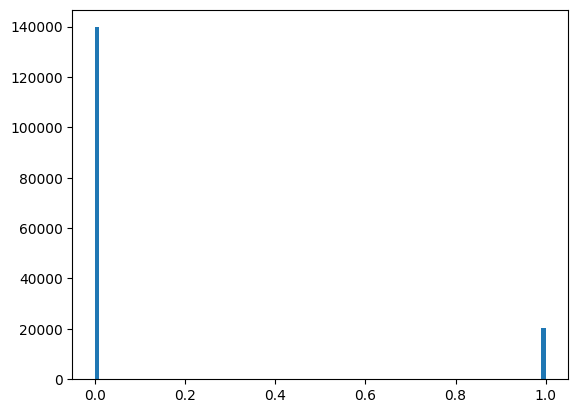

In [6]:
plt.hist(Box.ravel(), bins=100)
plt.show()

In [7]:
Box.shape

(400, 400)

In [8]:
Box_a=np.expand_dims(Box, axis=0)

In [9]:
Box_a.shape

(1, 400, 400)

In [10]:
d1 = PrimitiveTransformer(n_state=2, min_=0.0, max_=1.0).transform(Box_a)

In [11]:
d1.shape

(1, 400, 400, 2)

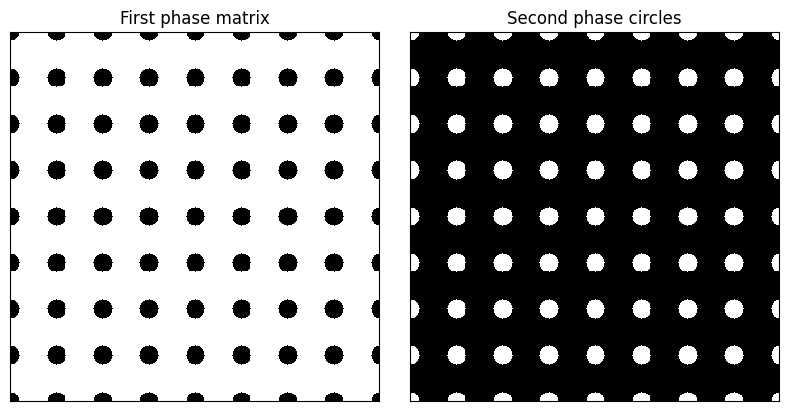

In [12]:
# first phase and second phase is considered 1
plot_microstructures(
    d1[0, :, :, 0],
    d1[0, :, :, 1],
    titles=['First phase matrix', 'Second phase circles'],
    cmap='gray',
    colorbar=False
);

**AUTO CORRELATIONS**

In [13]:
d1_corr = TwoPointCorrelation(
    periodic_boundary=True,
    cutoff=201,
    correlations=[(0, 0), (1, 1)]
).transform(d1)

In [14]:
d1_corr.shape

(1, 399, 399, 2)

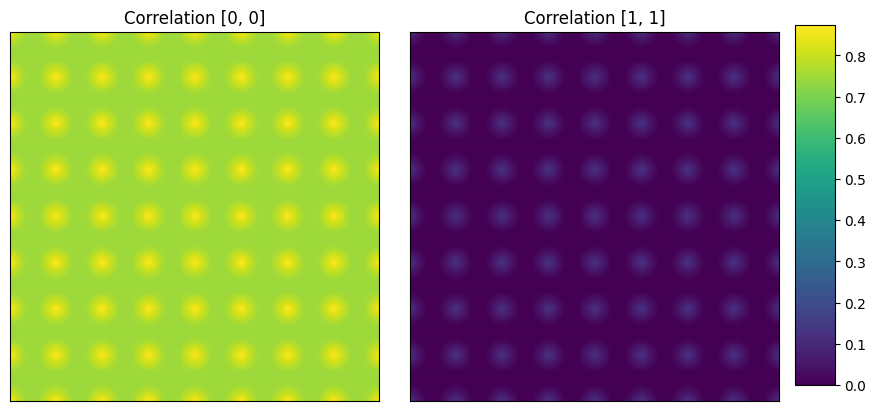

In [15]:
plot_microstructures(
    d1_corr[0,:, :, 0],
    d1_corr[0,:, :, 1],
    titles=['Correlation [0, 0]', 'Correlation [1, 1]']
);

**First image: (0,0) vector correspomding to volume fraction  of first phase, matrix is ~ 90%.**
**Second image: (0,0) vector correspomding to volume fraction  of second phase, circles is ~ 10%.**

**CROSS CORRELATION**

In [16]:
d1_corr_cr = TwoPointCorrelation(
    periodic_boundary=True,
    cutoff=201,
    correlations=[(0,0), (0, 1)]
).transform(d1)

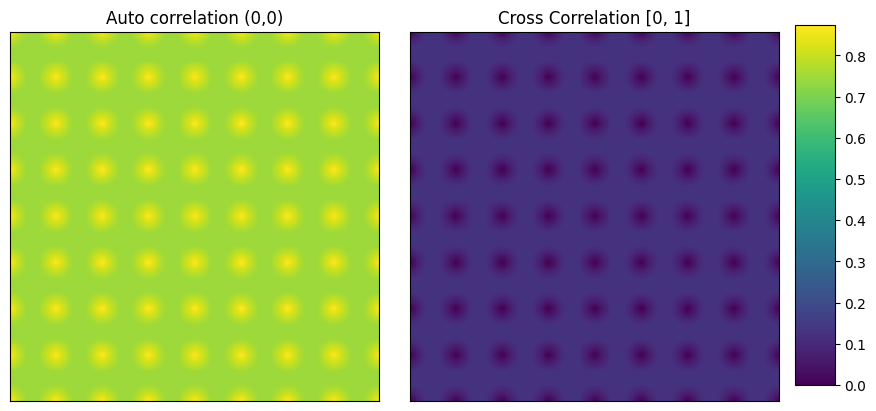

In [17]:
plot_microstructures(
    d1_corr_cr[0,:, :, 0],
    d1_corr_cr[0,:, :, 1],
    titles=['Auto correlation (0,0)','Cross Correlation [0, 1]']
);

**Checking volume fraction**

In [18]:
Box

array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]])

In [19]:
# matrix is black (designated as 0.0)
#MATRIX PHASE
count_m = 0
xsize = Box.shape[0]
ysize = Box.shape[1]
print(xsize)
print(ysize)
for i in range(0,xsize):
  for j in range(0,ysize):
    if Box[i,j] == 0.0:
      count_m += 1
print(count_m)
count_m/(xsize*ysize)

400
400
139712


0.8732

**Matrix phase: 87%**

In [20]:
# circle phase is white (designated as 1.0)

count_c = 0
xsize = Box.shape[0]
ysize = Box.shape[1]
print(xsize)
print(ysize)
for i in range(0,xsize):
  for j in range(0,ysize):
    if Box[i,j] == 1.0:
      count_c += 1
print(count_c)
count_c/(xsize*ysize)

400
400
20288


0.1268

**Circle phase is 13%**

**SEM-steel PEARLITE MICROSTRUCTURE**

In [21]:
im_s=io.imread('test2pt.jpg')

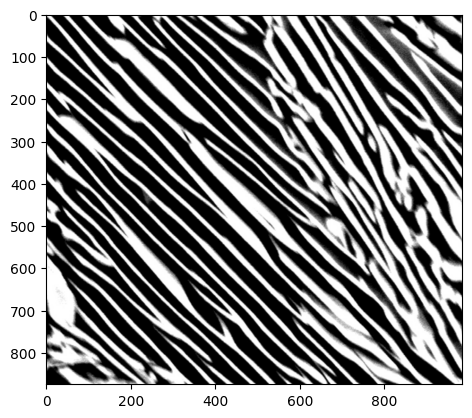

In [22]:
plt.imshow(im_s)

array([[[254, 254, 254],
        [254, 254, 254],
        [255, 255, 255],
        ...,
        [141, 141, 141],
        [167, 167, 167],
        [199, 199, 199]],

       [[252, 252, 252],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [100, 100, 100],
        [121, 121, 121],
        [156, 156, 156]],

       [[243, 243, 243],
        [249, 249, 249],
        [255, 255, 255],
        ...,
        [ 63,  63,  63],
        [ 77,  77,  77],
        [ 98,  98,  98]],

       ...,

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]], dtype=uint8)
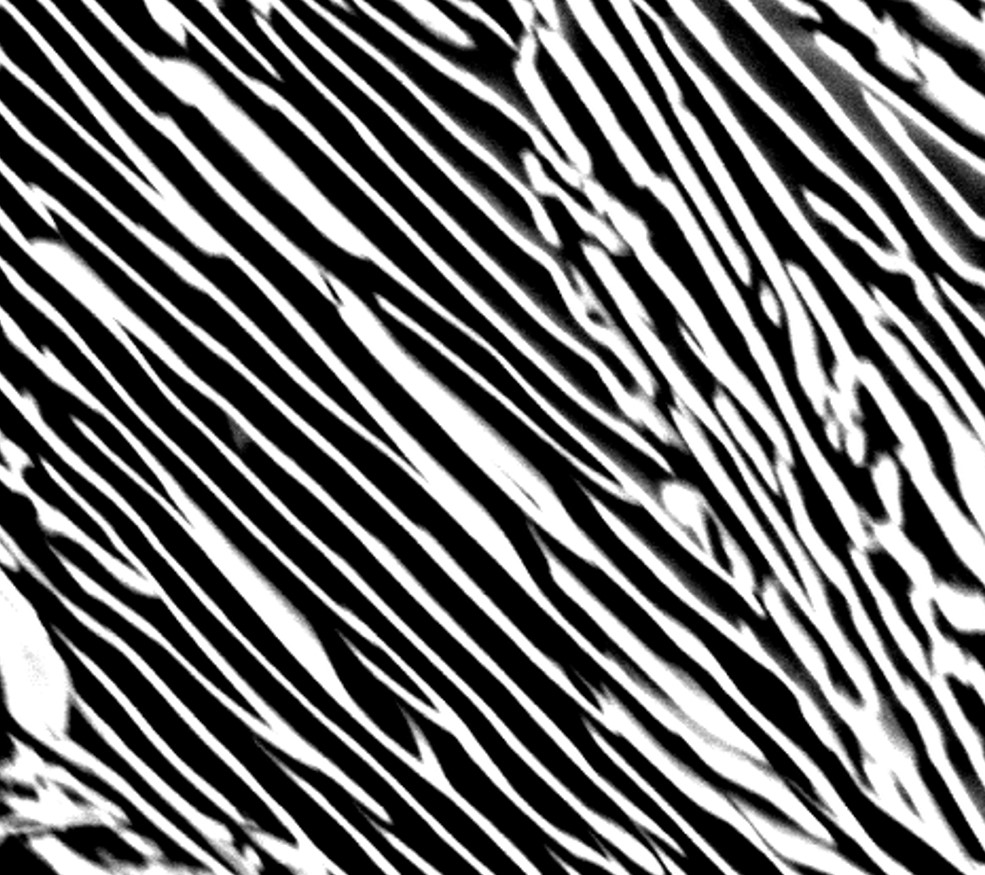

In [23]:
im_s

In [24]:
im_s.shape

(875, 985, 3)

In [25]:
im_s_g=rgb2gray(im_s)

In [26]:
im_s_g.shape

(875, 985)

In [27]:
im_s_g

array([[0.99607843, 0.99607843, 1.        , ..., 0.55294118, 0.65490196,
        0.78039216],
       [0.98823529, 1.        , 1.        , ..., 0.39215686, 0.4745098 ,
        0.61176471],
       [0.95294118, 0.97647059, 1.        , ..., 0.24705882, 0.30196078,
        0.38431373],
       ...,
       [0.        , 0.        , 0.        , ..., 1.        , 1.        ,
        1.        ],
       [0.        , 0.        , 0.        , ..., 1.        , 1.        ,
        1.        ],
       [0.        , 0.        , 0.        , ..., 1.        , 1.        ,
        1.        ]])

In [28]:
im_h=np.histogram(im_s_g, bins=100)
im_h

(array([329542,  23132,   6471,   7928,   4551,   6221,   3719,   5249,
          3338,   4824,   4568,   2950,   4158,   2717,   3964,   2532,
          3844,   2488,   3660,   2317,   3550,   3518,   2260,   3343,
          2180,   3315,   2199,   3329,   2037,   3064,   3025,   1970,
          2930,   1964,   2934,   1912,   2733,   1873,   2698,   1867,
          2729,   2602,   1728,   2533,   1726,   2621,   1723,   2533,
          1762,   2564,   2524,   1705,   2513,   1689,   2538,   1654,
          2487,   1704,   2602,   1697,   2527,   2535,   1753,   2525,
          1663,   2547,   1605,   2585,   1704,   2641,   2597,   1853,
          2602,   1880,   2895,   1885,   2890,   1998,   2868,   1987,
          2961,   3129,   1980,   3234,   2191,   3230,   2209,   3563,
          2536,   3894,   4092,   2939,   4609,   3288,   5382,   3940,
          7031,   6127,  23009, 202483]),
 array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
        0.11, 0.12, 

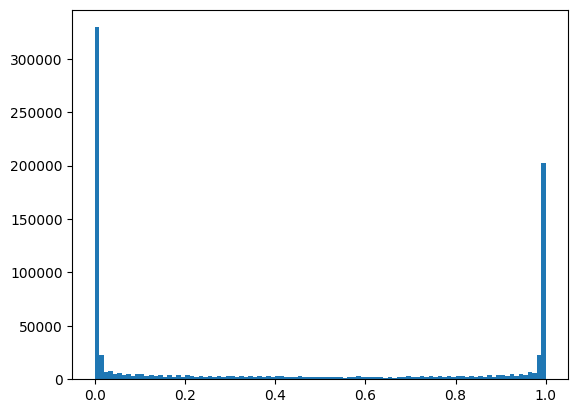

In [29]:
plt.hist(im_s_g.ravel(), bins=100)
plt.show()

In [30]:
im_s_g1=np.expand_dims(im_s_g, axis=0)


In [31]:
im_s_g1.shape

(1, 875, 985)

In [32]:
d2=PrimitiveTransformer(n_state=2, min_=0.0, max_=1.0).transform(im_s_g1)

In [33]:
d2.shape

(1, 875, 985, 2)

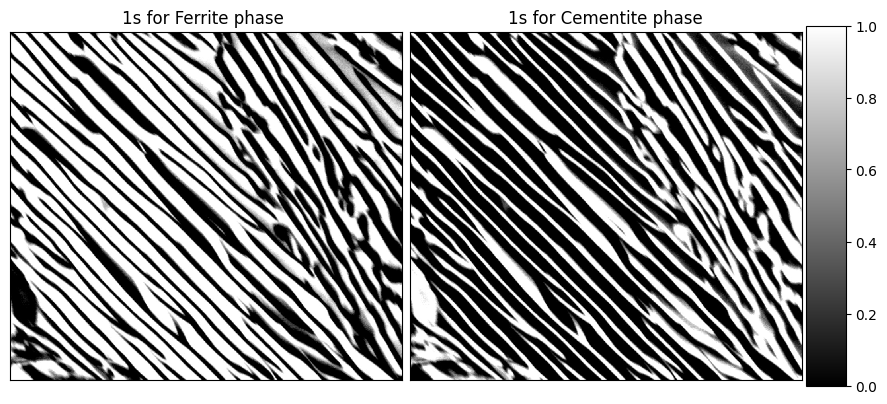

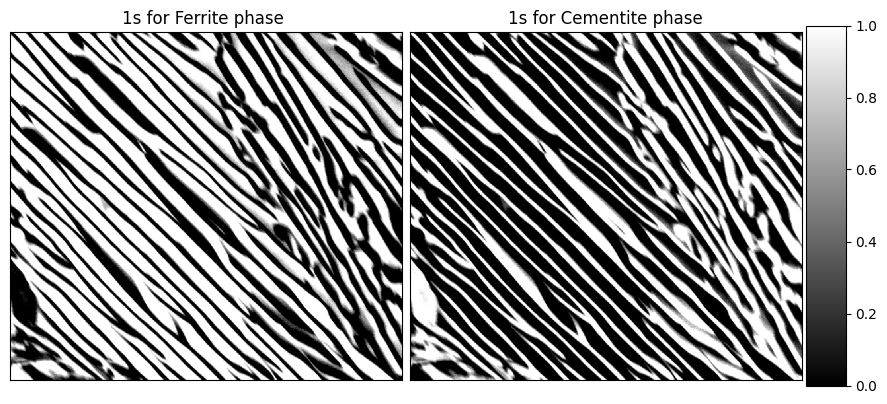

In [34]:
plot_microstructures(
d2[0,:, :, 0],
    d2[0,:, :, 1],
    titles=['1s for Ferrite phase ', '1s for Cementite phase'],cmap = 'gray')

First phase is ferrite, second phase cementite

In [35]:
d2_corr = TwoPointCorrelation(
    periodic_boundary=True,
    cutoff=500,
    correlations=[(0, 0), (1, 1)]
).transform(d2)

In [36]:
d2_corr.shape

(1, 875, 875, 2)

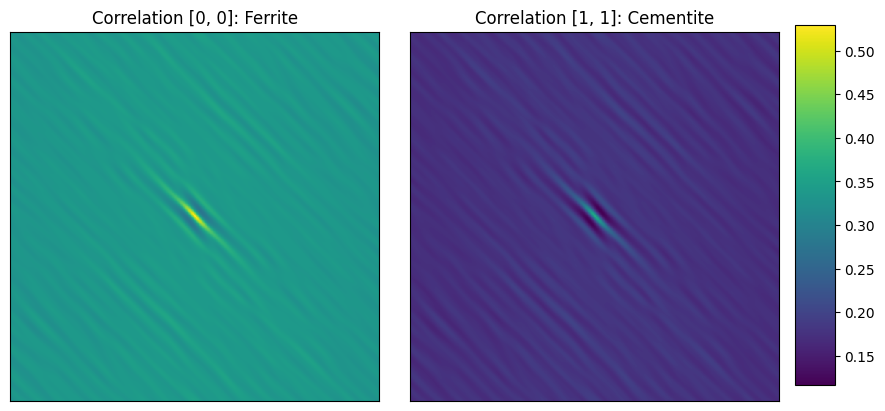

In [37]:
plot_microstructures(
    d2_corr[0,:, :, 0],
    d2_corr[0,:, :, 1],
    titles=['Correlation [0, 0]: Ferrite', 'Correlation [1, 1]: Cementite']
);

In [38]:
d2_corr_cr = TwoPointCorrelation(
    periodic_boundary=True,
    cutoff=500,
    correlations=[(0,1)]
).transform(d2)

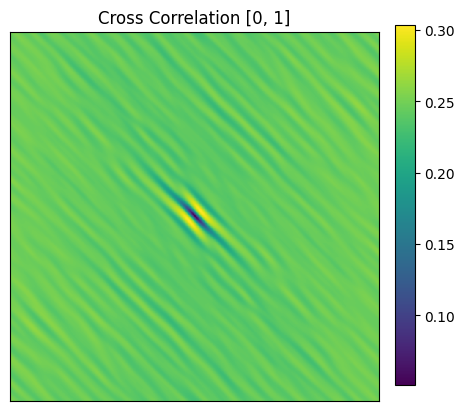

In [39]:
plot_microstructures(
       d2_corr_cr[0, :, :, 0],
    titles=['Cross Correlation [0, 1]'],
    #showticks=True
);

**Ferrite is ~55%; Cementite ~ 30%**

**Checking volume fraction**

In [40]:
min=np.min(im_s_g)
min

0.0

In [41]:
max=np.max(im_s_g)
max

1.0

In [42]:
xsize = im_s_g.shape[0]
ysize = im_s_g.shape[1]
print(xsize)
print(ysize)

875
985


**White phase correspond to cementite in original micrograph. volume fraction calculated ~ 31%**

In [43]:
count_w_s = 0
for i in range(0,xsize):
  for j in range(0,ysize):
    if im_s_g[i,j] > 0.9:
      count_w_s += 1
print(count_w_s)
count_w_s/(xsize*ysize)

262900


0.305032632342277

**Dark region corresponds to ferrite ~ 46%**

In [44]:
count_b_s = 0
for i in range(0,xsize):
  for j in range(0,ysize):
    if im_s_g[i,j] < 0.1:
      count_b_s += 1
print(count_b_s)
count_b_s/(xsize*ysize)

394975


0.4582741116751269